# Task 3: Energy Consumption Time Series Forecasting

## Objective
The goal of this task is to forecast short-term household energy usage using historical time-based patterns.

## Dataset
We use the **Household Power Consumption Dataset**.  
Each row represents measurements of electric power consumption in one household, recorded every minute.

**Columns:**
- Date, Time
- Global_active_power (kW)
- Global_reactive_power (kW)
- Voltage (V)
- Global_intensity (A)
- Sub_metering_1 (Watt-hour)
- Sub_metering_2 (Watt-hour)
- Sub_metering_3 (Watt-hour)

We will:
1. Parse and resample the time series data  
2. Engineer time-based features (hour, weekday/weekend, etc.)  
3. Compare **ARIMA, Prophet, and XGBoost** models  
4. Evaluate performance (MAE, RMSE)  
5. Visualize actual vs. forecasted usage

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from xgboost import XGBRegressor

import warnings
warnings.filterwarnings("ignore")

C:\Users\Others\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


## Dataset Loading & Initial Inspection
We first load the dataset `household_power_consumption.csv`, parse the Date and Time columns into a DateTime index, and check for missing values.

In [2]:
# Load dataset
df = pd.read_csv("household_power_consumption.csv", sep=",", parse_dates=[[0,1]], 
                 infer_datetime_format=True, low_memory=False)

# Rename datetime column
df.rename(columns={'Date_Time': 'Datetime'}, inplace=True)
df.set_index('Datetime', inplace=True)

# Check dataset info
print(df.head())
print(df.info())

                    Global_active_power Global_reactive_power Voltage  \
Datetime                                                                
2006-12-16 17:24:00               4.216                 0.418  234.84   
2006-12-16 17:25:00                5.36                 0.436  233.63   
2006-12-16 17:26:00               5.374                 0.498  233.29   
2006-12-16 17:27:00               5.388                 0.502  233.74   
2006-12-16 17:28:00               3.666                 0.528  235.68   

                    Global_intensity Sub_metering_1 Sub_metering_2  \
Datetime                                                             
2006-12-16 17:24:00             18.4              0              1   
2006-12-16 17:25:00               23              0              1   
2006-12-16 17:26:00               23              0              2   
2006-12-16 17:27:00               23              0              1   
2006-12-16 17:28:00             15.8              0              1  

## Data Cleaning & Preprocessing
- Convert columns to numeric  
- Handle missing values  
- Resample data to hourly consumption (instead of minute level for simplicity)  
- Focus on `Global_active_power` as the target variable

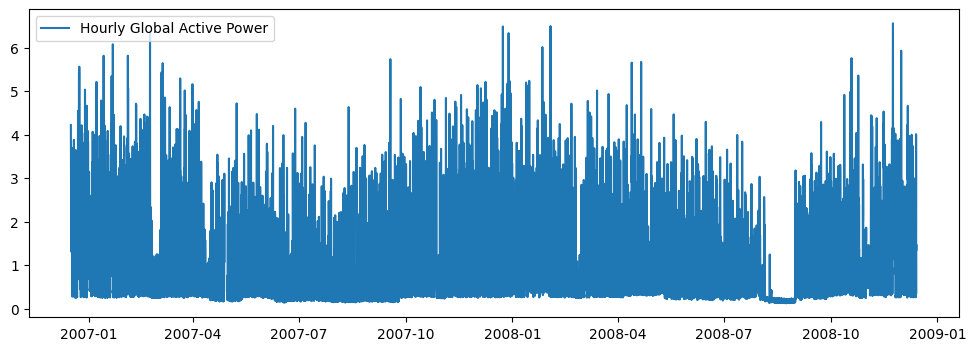

In [3]:
# Convert to numeric
df = df.apply(pd.to_numeric, errors='coerce')

# Handle missing values
df = df.dropna()

# Resample to hourly average
df_hourly = df['Global_active_power'].resample('H').mean()

# Plot
plt.figure(figsize=(12,4))
plt.plot(df_hourly, label='Hourly Global Active Power')
plt.legend()
plt.show()

## Feature Engineering
We add time-based features:
- Hour of day  
- Day of week  
- Weekend indicator

In [4]:
features = pd.DataFrame(df_hourly)
features = features.reset_index()
features['hour'] = features['Datetime'].dt.hour
features['day_of_week'] = features['Datetime'].dt.dayofweek
features['is_weekend'] = (features['day_of_week'] >= 5).astype(int)
features.head()

,Datetime,Global_active_power,hour,day_of_week,is_weekend
0,2006-12-16 17:00:00,4.222889,17,5,1
1,2006-12-16 18:00:00,3.632200,18,5,1
2,2006-12-16 19:00:00,3.400233,19,5,1
3,2006-12-16 20:00:00,3.268567,20,5,1
4,2006-12-16 21:00:00,3.056467,21,5,1


## Train-Test Split
We use the last 20% of the data for testing and the rest for training.

In [5]:
split = int(len(df_hourly)*0.8)
train = df_hourly[:split]
test = df_hourly[split:]

## ARIMA Model
We build and evaluate an ARIMA model on the time series.

In [6]:
# Train ARIMA
model_arima = ARIMA(train, order=(5,1,2))
arima_fit = model_arima.fit()

# Forecast
forecast_arima = arima_fit.forecast(steps=len(test))

# Evaluate
mae_arima = mean_absolute_error(test, forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test, forecast_arima))

print("ARIMA -> MAE:", mae_arima, " RMSE:", rmse_arima)

ARIMA -> MAE: 0.6830334321116263  RMSE: 0.9072490832742891


## Prophet Model
We use Facebook Prophet for time series forecasting.

In [7]:
# Prepare data
df_prophet = df_hourly.reset_index()
df_prophet.columns = ['ds', 'y']

train_prophet = df_prophet.iloc[:split]
test_prophet = df_prophet.iloc[split:]

# Train Prophet
model_prophet = Prophet()
model_prophet.fit(train_prophet)

# Forecast
future = model_prophet.make_future_dataframe(periods=len(test), freq='H')
forecast_prophet = model_prophet.predict(future)

# Evaluation
forecast_values = forecast_prophet['yhat'].iloc[-len(test):].values
mae_prophet = mean_absolute_error(test.values, forecast_values)
rmse_prophet = np.sqrt(mean_squared_error(test.values, forecast_values))

print("Prophet -> MAE:", mae_prophet, " RMSE:", rmse_prophet)

13:27:43 - cmdstanpy - INFO - Chain [1] start processing
13:27:52 - cmdstanpy - INFO - Chain [1] done processing


Prophet -> MAE: 0.7071093497343084  RMSE: 0.9415046597681839


## XGBoost Model
We train a gradient boosting model using time features.

In [11]:
# Features for XGBoost
X = features[['hour','day_of_week','is_weekend']]
y = features['Global_active_power']

X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

import numpy as np
y_train = y_train.fillna(y_train.mean())  # There were 62 NaN values, so replacing them with a number

# Train XGBoost
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5)
model_xgb.fit(X_train, y_train)

# Forecast
forecast_xgb = model_xgb.predict(X_test)

# Evaluate
mae_xgb = mean_absolute_error(y_test, forecast_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y_test, forecast_xgb))

print("XGBoost -> MAE:", mae_xgb, " RMSE:", rmse_xgb)

XGBoost -> MAE: 0.619403122072421  RMSE: 0.8208124819385154


## Model Comparison & Visualization
We compare the three models (ARIMA, Prophet, XGBoost) and visualize actual vs forecasted energy usage.

     Model       MAE      RMSE
0    ARIMA  0.683033  0.907249
1  Prophet  0.707109  0.941505
2  XGBoost  0.619403  0.820812


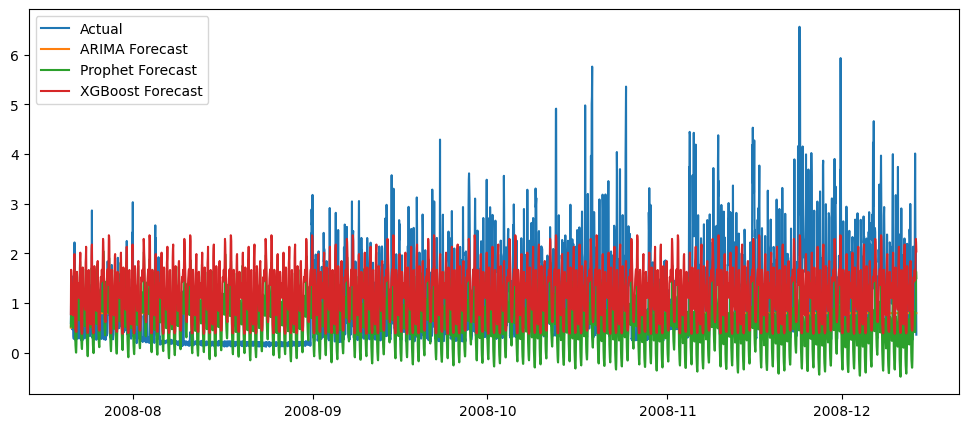

In [12]:
# Compare
results = pd.DataFrame({
    'Model': ['ARIMA', 'Prophet', 'XGBoost'],
    'MAE': [mae_arima, mae_prophet, mae_xgb],
    'RMSE': [rmse_arima, rmse_prophet, rmse_xgb]
})
print(results)

# Plot
plt.figure(figsize=(12,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast')
plt.plot(test.index, forecast_values, label='Prophet Forecast')
plt.plot(test.index, forecast_xgb, label='XGBoost Forecast')
plt.legend()
plt.show()

## Conclusion
- We built three forecasting models: **ARIMA, Prophet, and XGBoost**  
- Performance was compared using MAE and RMSE  
- Visualizations showed how each model captures time-based energy consumption patterns  
- The best model can be selected based on lowest RMSE  

Skills Gained:
- Time series forecasting  
- Feature engineering for temporal data  
- Model evaluation (MAE, RMSE)  
- Comparative analysis of classical (ARIMA), statistical (Prophet), and machine learning (XGBoost) methods  